In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import cv2
from PIL import Image
from skimage import data, exposure
from skimage.feature import hog,local_binary_pattern
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from numpy.random import seed
import pickle
from tqdm import tqdm

import pytz
from datetime import datetime
from collections import Counter
import math

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()

In [2]:
!pip install unidecode

def norm_text(txt):
  from unidecode import unidecode
  return unidecode(txt).replace(' ','_').lower()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 3.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
config_dir = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/config/'
model_save_dir = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/model/'
erro_dir = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/error/'
log_dir = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/log/'

In [5]:
import sys
sys.path.append('/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/Modelos_Implementações')

In [6]:
import MLP as mlp # multilayer perceptron
import Multinomial_LogReg # regressão logística com alpha variavel (bissecao)
import R_LOG as r_log # regressão logística com alpha fixo
import SVM_OVR # SVM one-versus-rest
import ANN

In [ ]:
# import importlib

# importlib.reload(ANN)
# importlib.reload(mlp)
# importlib.reload(Multinomial_LogReg)
# importlib.reload(r_log)
# importlib.reload(SVM_OVR)
# importlib.reload(ANN)

In [7]:
class logfile():

  def __init__(self, diretorio):
    self.diretorio=diretorio

  def start(self, tag, use_dateref=True):
    if use_dateref:
      tag = tag + '_' + datetime.now(pytz.timezone('America/Bahia')).strftime("%Y%m%d")
    self.save_file = open(self.diretorio +  tag + '.txt', 'w')
    data_atual = datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")
    print('Execução em:', data_atual, file=self.save_file)
    
  def end(self):
    data_atual = datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")
    print('Fim de Execução em:', data_atual, file=self.save_file)
    self.save_file.close()

In [8]:
# Visualize Dataset

In [9]:
def generate_image_db(keep_images):
  import zipfile
  from skimage.transform import resize


  imagens_path = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/CelebA/img_align_celeba.zip'
  imgzip = zipfile.ZipFile(imagens_path)
  inflist = imgzip.infolist()
  all_images = {}

  for f in tqdm(inflist):
    file_name = f.filename.split('/')[1]
    if file_name in keep_images:
      if '.jpg' in file_name:
        ifile = imgzip.open(f)
        img = Image.open(ifile)
        img_resize = resize(np.array(img), (128, 128))
        all_images[file_name] = [img_resize]

  return all_images

def plt_samples(imgs):
  # faces que foram reconhecidas pelo viola jones
  fig, axes = plt.subplots(1,5, figsize=(10,10))

  imgs= pd.DataFrame(imgs)

  for (i,row), ax in zip(imgs.head(8).iterrows(), axes.ravel()): 
    ax.axis('off')
    ax.imshow(row[0], cmap=plt.cm.gray)

def visualize_5photos(y):
  amostra= generate_image_db(y.sample(5).index)
  amostra_df = pd.DataFrame(amostra).T.reset_index()
  plt_samples(amostra_df)

# Carregando Dataset - LBP

In [10]:
n_classes=50
ref = 'LBP' 
tag= 'lbp' + '_'+ str(n_classes) + '_classes'


with open(r'/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/Data/X_y_' + tag +'.obj', "rb") as f:
    X,y = pickle.load(f)

100%|██████████| 202600/202600 [00:04<00:00, 45065.35it/s]


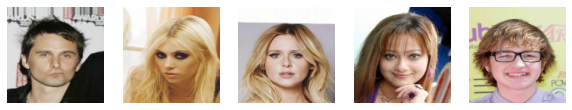

In [11]:
visualize_5photos(y)

In [12]:
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (1443, 2500)
y shape: (1443,)


In [13]:
# transformar categorias em one-hot-encoding: Saída
saida = y.max()+1
print("Quantidade de pessoas:",saida)
target = keras.utils.to_categorical(y, saida)

Quantidade de pessoas: 50


# Train x Test

In [14]:
def train_test_separation(X, y):

  n_classes = len(np.unique(y))

  x_train, x_test, y_train_n, y_test_n = train_test_split(X, y, test_size=0.30, random_state=42,stratify=y)

  y_train = keras.utils.to_categorical(y_train_n.values, n_classes)
  y_test = keras.utils.to_categorical(y_test_n.values, n_classes)

  assert y_train.shape[0]== y_train_n.shape[0]
  assert y_test.shape[0]== y_test_n.shape[0]

  print('x_train shape:', x_train.shape,'y_train shape:',  y_train_n.shape, 'y_train (ohe) shape:' ,y_train.shape, 'x_test shape:',  x_test.shape,'y_test shape:', y_test_n.shape,'y_test (ohe) shape:', y_test.shape)

  return x_train, y_train_n, y_train, x_test, y_test, y_test_n

In [15]:
def apply_PCA(n_pca, x_train,x_test, norm_entry=False):

  if norm_entry:
    x_train = (x_train - x_train.mean(axis=0))/  x_train.std(axis=0)
    x_test = (x_test - x_train.mean(axis=0))/  x_train.std(axis=0)
  else:
    pass

  pca = PCA(n_components=n_pca, random_state=42)
  pca.fit(x_train)

  print('variancia explicada:', sum(pca.explained_variance_ratio_))
  x_train_pca = pca.transform(x_train)
  x_test_pca = pca.transform(x_test)

  x_train_pca_norm = (x_train_pca - x_train_pca.mean(axis=0))/  x_train_pca.std(axis=0)
  x_test_pca_norm = (x_test_pca - x_train_pca.mean(axis=0))/  x_train_pca.std(axis=0)

  return x_train_pca_norm, x_test_pca_norm

In [16]:
X_train, y_train_n, y_train, X_test, y_test, y_test_n = train_test_separation(X,y)

x_train shape: (1010, 2500) y_train shape: (1010,) y_train (ohe) shape: (1010, 50) x_test shape: (433, 2500) y_test shape: (433,) y_test (ohe) shape: (433, 50)


In [17]:
X_train_pca, X_test_pca = apply_PCA(n_pca=50, x_train=X_train, x_test=X_test,norm_entry=True)

variancia explicada: 0.21517671365250535


In [18]:
def unpack_dict_as_str(dicionario):
  string=''

  for k,v in dicionario.items():
    string= string + str(k) + ':[ '
    try:
      for v_ in v:
        string= string + str(v_) + ' '
      string= string+'] '
    except:
      string= string + str(v) + '] '
  return string.strip()

# unpack_dict_as_str({'a':[2,5,6], 'b':[6,7]})

In [19]:
def pipeline_integrated_onedim(nome_do_modelo, #nome do modelo
                               classifier, # classificador
                               param_iteracao, # parametro iteração - deve conter um dicionario com a lista de valores a ser iterado
                               param_fixo,  # parametro fixo e respectivo valor (uma lista)
                               data, # dicionario de treino e teste
                               kf= KFold(n_splits=5, shuffle=True, random_state=42),
                               neural_network=False): #kfold

  print('Pipeline de testes para o modelo:', nome_do_modelo)
  X_train = data['X_train']
  X_test = data['X_test']
  y_train = data['y_train']
  y_test = data['y_test']

  log={}
  log['exec_time'] = 'Execução em: {}'.format(datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S"))
  log['model_name'] = nome_do_modelo
  log['parametro_fixo'] = '{}:[{}]'.format(param_fixo[0], param_fixo[1])
  log['parametro_variavel'] = unpack_dict_as_str(param_iteracao)
  log['kfold'] = kf

  best_acc_val = -1
  best_model=None
  best_param = None
  it=0

  for parametro, valores in param_iteracao.items():
    cv_report = {}
    for valor in valores:
      it+=1

      cv_report['cv_results_'+str(it)] = {}
      print('Execução em: {}'.format(datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")))
      print("====================================================================")
      print('iteração:{}'.format(it))
      param = {parametro:valor}
      param[param_fixo[0]] = param_fixo[1]
      print('Testando parametros:\n', unpack_dict_as_str(param))
      print("====================================================================")
      
      cv_report['cv_results_'+str(it)]['cv_param']= unpack_dict_as_str(param)

      for k_index,(train_index, val_index) in enumerate(kf.split(X_train)):
        print('cross-validation: {}'.format(k_index))
        X_train_kf, X_val_kf = X_train[train_index], X_train[val_index]
        y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]

        # Ajusta o parâmetro usando o dicionário
        for k,v in param.items():
          setattr(classifier,k,v)
        
        if neural_network:
          classifier.fit(X_train_kf, y_train_kf,[X_val_kf,y_val_kf])
          acc_train = accuracy_score(classifier.predict(X_train_kf), y_train_kf.argmax(axis=1))
          acc_val = accuracy_score(classifier.predict(X_val_kf), y_val_kf.argmax(axis=1))
          acc_test = accuracy_score(classifier.predict(X_test), y_test.argmax(axis=1))
        else:
          classifier.fit(X_train_kf, y_train_kf)
          acc_train = accuracy_score(classifier.predict(X_train_kf), y_train_kf)
          acc_val = accuracy_score(classifier.predict(X_val_kf), y_val_kf)
          acc_test = accuracy_score(classifier.predict(X_test), y_test)
        print('acc - tr:{:.2f} val:{:.2f} tst:{:.2f}'.format(acc_train,acc_val,acc_test ))


        if acc_val>best_acc_val:
          best_model=classifier
          best_param = param
          k_index_best = k_index
          best_acc_val=acc_val

        cv_report['cv_results_'+str(it)]['acc_train_'+str(k_index)] = acc_train
        cv_report['cv_results_'+str(it)]['acc_val_'+ str(k_index)] = acc_val
        cv_report['cv_results_'+str(it)]['acc_test_'+ str(k_index)] = acc_test

    log['cv_report']= cv_report

    if neural_network:
      best_model.fit(X_train, y_train,[X_test,y_test])
      acc_train_best_model = accuracy_score(best_model.predict(X_train), y_train.argmax(axis=1))
      acc_test_best_model = accuracy_score(best_model.predict(X_test), y_test.argmax(axis=1))
    else:
      best_model.fit(X_train, y_train)
      acc_train_best_model = accuracy_score(best_model.predict(X_train), y_train)
      acc_test_best_model = accuracy_score(best_model.predict(X_test), y_test)
    

    print('Melhor acurácia no validação obtida com os parametros {}. Treino final: {:.4f} Teste:{:.4f}'.format(unpack_dict_as_str(best_param),acc_train_best_model, acc_test_best_model))
    print('Fim da Execução: {}'.format(datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")))
    
    log['melhor_modelo_obj'] = best_model
    log['best_param_k_fold'] = unpack_dict_as_str(best_param)
    log['acc_train_best_model'] = acc_train_best_model
    log['acc_test_best_model'] = acc_test_best_model

    return log

def dictlog_to_flat_table(log):
  log_i = pd.DataFrame(log, index=[norm_text(modelo)])
  cv_log_i = pd.DataFrame(log['cv_report']).T.reset_index().assign(modelo = norm_text(modelo))
  cv_log_i = pd.merge(log_i,cv_log_i, left_index = True , right_on = 'modelo', how='outer').drop(columns='cv_report')
  return cv_log_i

# Teste com Modelos

In [20]:
logs = pd.DataFrame()

Regressão Logística

In [ ]:
modelo = 'Regressão Logística Multinomial Passo Fixo'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier= Multinomial_LogReg.MultinomialLogReg(),
                          param_iteracao= {'alpha':[0.1]},
                          param_fixo=['theta',0.001],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train_n, 'y_test':y_test_n} )

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df,ignore_index=True)

Pipeline de testes para o modelo: Regressão Logística Multinomial Passo Fixo
Execução em: 21/01/2023 12:57:26
iteração:1
Testando parametros:
 alpha:[ 0.1] theta:[ 0.001]
cross-validation: 0
it:10000, norm_grad:0.03328971355301112, J:1.1160458109571996
it:20000, norm_grad:0.01669686664940835, J:0.5602450579818398
it:30000, norm_grad:0.011145405188465416, J:0.3741548093459853
it:40000, norm_grad:0.008365347317587325, J:0.28092001506977565
it:50000, norm_grad:0.006695757443971808, J:0.22490766559362418
it:60000, norm_grad:0.00558197756030803, J:0.18753202226902038
it:70000, norm_grad:0.004786032870062906, J:0.16081642003991686
it:80000, norm_grad:0.0041888435111237755, J:0.14076841568560539
it:90000, norm_grad:0.003724215123369418, J:0.12516821209486714
it:100000, norm_grad:0.0033524125224604516, J:0.11268306756921606
it:110000, norm_grad:0.003048139941651214, J:0.10246441382612685
it:120000, norm_grad:0.0027945280437525213, J:0.09394627610217861
it:130000, norm_grad:0.002579894776140339

In [ ]:
modelo = 'Regressão Logística Multinomial com Bisseção'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier= Multinomial_LogReg.MultinomialLogReg_bissecao(),
                          param_iteracao= {'itmax_bissec':[20]},
                          param_fixo=['theta',0.001],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train_n, 'y_test':y_test_n} )

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df,ignore_index=True)

Pipeline de testes para o modelo: Regressão Logística Multinomial com Bisseção
Execução em: 21/01/2023 22:56:51
iteração:1
Testando parametros:
 itmax_bissec:[ 20] theta:[ 0.001]
cross-validation: 0
iteracao: 0 norm_grad: 363.4577603059499
it:1000, norm_grad:9.761312671523054, J:295.79397703778255, alpha_b:8.97096631882243e-08, hl:87.06115591433355
it:2000, norm_grad:1.6962594828977875, J:45.09983032919544, alpha_b:4.46758969405771e-07, hl:16.518272928006997
it:3000, norm_grad:1.2790172418200383, J:19.707973567923265, alpha_b:2.1792595370105018e-07, hl:4.3417179325490265
it:4000, norm_grad:0.0037671216144131293, J:0.11137469633864173, alpha_b:14.6008209158462, hl:2.005355825832955e-05
it:4225, norm_grad:0.0009680878219950565, J:0.03137821666977043, alpha_b:41.09692838857992, hl:2.6360588113319165e-06
acc - tr:1.00 val:0.16 tst:0.04
cross-validation: 1
iteracao: 0 norm_grad: 367.0529160819518
it:1000, norm_grad:8.437073289178677, J:98.47058135696948, alpha_b:7.033863915903511e-08, hl:20

# SVM

In [ ]:
modelo = 'SVM Classificador Kernel RBF C=1'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier=  SVM_OVR.SVM_one_vs_all(),
                          param_iteracao= {'sigma':[0.01, 0.1,1]},
                          param_fixo=['C',1],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train_n, 'y_test':y_test_n})

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df,ignore_index=True)

Pipeline de testes para o modelo: SVM Classificador Kernel RBF C=1
Execução em: 21/01/2023 18:08:15
iteração:1
Testando parametros:
 sigma:[ 0.01] C:[ 1]
cross-validation: 0


100%|██████████| 50/50 [00:15<00:00,  3.13it/s]


acc - tr:1.00 val:0.02 tst:0.02
cross-validation: 1


100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


acc - tr:1.00 val:0.01 tst:0.02
cross-validation: 2


100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


acc - tr:1.00 val:0.02 tst:0.02
cross-validation: 3


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


acc - tr:1.00 val:0.03 tst:0.02
cross-validation: 4


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


acc - tr:1.00 val:0.02 tst:0.02
Execução em: 21/01/2023 18:19:34
iteração:2
Testando parametros:
 sigma:[ 0.1] C:[ 1]
cross-validation: 0


100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


acc - tr:1.00 val:0.05 tst:0.02
cross-validation: 1


100%|██████████| 50/50 [00:16<00:00,  3.00it/s]


acc - tr:1.00 val:0.02 tst:0.02
cross-validation: 2


100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


acc - tr:1.00 val:0.05 tst:0.02
cross-validation: 3


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


acc - tr:1.00 val:0.07 tst:0.02
cross-validation: 4


100%|██████████| 50/50 [00:15<00:00,  3.13it/s]


acc - tr:1.00 val:0.03 tst:0.02
Execução em: 21/01/2023 18:30:48
iteração:3
Testando parametros:
 sigma:[ 1] C:[ 1]
cross-validation: 0


100%|██████████| 50/50 [00:14<00:00,  3.34it/s]


acc - tr:1.00 val:0.19 tst:0.03
cross-validation: 1


100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


acc - tr:1.00 val:0.20 tst:0.02
cross-validation: 2


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


acc - tr:1.00 val:0.23 tst:0.02
cross-validation: 3


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


acc - tr:1.00 val:0.20 tst:0.05
cross-validation: 4


100%|██████████| 50/50 [00:15<00:00,  3.25it/s]


acc - tr:1.00 val:0.23 tst:0.02


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Melhor acurácia no validação obtida com os parametros sigma:[ 1] C:[ 1]. Treino final: 1.0000 Teste:0.0231
Fim da Execução: 21/01/2023 18:44:24


In [ ]:
modelo = 'SVM Classificador Kernel RBF C=100'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier=  SVM_OVR.SVM_one_vs_all(),
                          param_iteracao= {'sigma':[0.01, 0.1,1]},
                          param_fixo=['C',100],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train_n, 'y_test':y_test_n})

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df)

Pipeline de testes para o modelo: SVM Classificador Kernel RBF C=100
Execução em: 21/01/2023 18:44:24
iteração:1
Testando parametros:
 sigma:[ 0.01] C:[ 100]
cross-validation: 0


100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


acc - tr:1.00 val:0.02 tst:0.02
cross-validation: 1


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


acc - tr:1.00 val:0.01 tst:0.02
cross-validation: 2


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


acc - tr:1.00 val:0.02 tst:0.02
cross-validation: 3


100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


acc - tr:1.00 val:0.03 tst:0.02
cross-validation: 4


100%|██████████| 50/50 [00:16<00:00,  3.05it/s]


acc - tr:1.00 val:0.02 tst:0.02
Execução em: 21/01/2023 18:55:46
iteração:2
Testando parametros:
 sigma:[ 0.1] C:[ 100]
cross-validation: 0


100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


acc - tr:1.00 val:0.05 tst:0.02
cross-validation: 1


100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


acc - tr:1.00 val:0.02 tst:0.02
cross-validation: 2


100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


acc - tr:1.00 val:0.05 tst:0.02
cross-validation: 3


100%|██████████| 50/50 [00:16<00:00,  3.05it/s]


acc - tr:1.00 val:0.07 tst:0.02
cross-validation: 4


100%|██████████| 50/50 [00:16<00:00,  3.05it/s]


acc - tr:1.00 val:0.03 tst:0.02
Execução em: 21/01/2023 19:07:10
iteração:3
Testando parametros:
 sigma:[ 1] C:[ 100]
cross-validation: 0


100%|██████████| 50/50 [00:15<00:00,  3.26it/s]


acc - tr:1.00 val:0.19 tst:0.03
cross-validation: 1


100%|██████████| 50/50 [00:15<00:00,  3.28it/s]


acc - tr:1.00 val:0.20 tst:0.02
cross-validation: 2


100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


acc - tr:1.00 val:0.23 tst:0.02
cross-validation: 3


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


acc - tr:1.00 val:0.20 tst:0.05
cross-validation: 4


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


acc - tr:1.00 val:0.23 tst:0.02


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Melhor acurácia no validação obtida com os parametros sigma:[ 1] C:[ 100]. Treino final: 1.0000 Teste:0.0231
Fim da Execução: 21/01/2023 19:20:47


In [ ]:
modelo = 'SVM Classificador Kernel RBF C=1000'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier=  SVM_OVR.SVM_one_vs_all(),
                          param_iteracao= {'sigma':[0.001, 0.1,1]},
                          param_fixo=['C',1000],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train_n, 'y_test':y_test_n})

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df)

Pipeline de testes para o modelo: SVM Classificador Kernel RBF C=1000
Execução em: 21/01/2023 19:31:16
iteração:1
Testando parametros:
 sigma:[ 0.001] C:[ 1000]
cross-validation: 0


100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


acc - tr:1.00 val:0.02 tst:0.02
cross-validation: 1


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


acc - tr:1.00 val:0.01 tst:0.02
cross-validation: 2


100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


acc - tr:1.00 val:0.02 tst:0.02
cross-validation: 3


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


acc - tr:1.00 val:0.03 tst:0.02
cross-validation: 4


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


acc - tr:1.00 val:0.02 tst:0.02
Execução em: 21/01/2023 19:42:32
iteração:2
Testando parametros:
 sigma:[ 0.1] C:[ 1000]
cross-validation: 0


100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


acc - tr:1.00 val:0.05 tst:0.02
cross-validation: 1


100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


acc - tr:1.00 val:0.02 tst:0.02
cross-validation: 2


100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


acc - tr:1.00 val:0.05 tst:0.02
cross-validation: 3


100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


acc - tr:1.00 val:0.07 tst:0.02
cross-validation: 4


100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


acc - tr:1.00 val:0.03 tst:0.02
Execução em: 21/01/2023 19:53:49
iteração:3
Testando parametros:
 sigma:[ 1] C:[ 1000]
cross-validation: 0


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


acc - tr:1.00 val:0.19 tst:0.03
cross-validation: 1


100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


acc - tr:1.00 val:0.20 tst:0.02
cross-validation: 2


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


acc - tr:1.00 val:0.23 tst:0.02
cross-validation: 3


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


acc - tr:1.00 val:0.20 tst:0.05
cross-validation: 4


100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


acc - tr:1.00 val:0.23 tst:0.02


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Melhor acurácia no validação obtida com os parametros sigma:[ 1] C:[ 1000]. Treino final: 1.0000 Teste:0.0231
Fim da Execução: 21/01/2023 20:07:29


# MLP

In [21]:
modelo = 'MultiLayer Perceptron alpha 0.1'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier=  ANN.RNA(),
                          param_iteracao= {'h':[25,50,100]},
                          param_fixo=['alpha',0.1],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train, 'y_test':y_test},
                          neural_network=True)

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df,ignore_index=True)

Pipeline de testes para o modelo: MultiLayer Perceptron alpha 0.1
Execução em: 22/01/2023 17:59:33
iteração:1
Testando parametros:
 h:[ 25] alpha:[ 0.1]
cross-validation: 0
nep: 10000 EQM: 42.68826025979719 EQM_val: 0.9860550411886777 norm: 0.002305198144313729
nep: 20000 EQM: 42.68826025979719 EQM_val: 0.9803653057497732 norm: 0.0039533310355653805
nep: 30000 EQM: 42.68826025979719 EQM_val: 0.9628058925077568 norm: 0.005467796980886156
nep: 40000 EQM: 42.68826025979719 EQM_val: 0.9414194620605072 norm: 0.0062318422727261225
nep: 50000 EQM: 42.68826025979719 EQM_val: 0.9292883268934603 norm: 0.006152399125247679
Convergência em 50000 epochs
acc - tr:0.37 val:0.18 tst:0.07
cross-validation: 1
nep: 10000 EQM: 42.51992927090725 EQM_val: 0.989715503481235 norm: 0.002283162612658985
nep: 20000 EQM: 42.51992927090725 EQM_val: 0.9844123249093008 norm: 0.004649420997492383
nep: 30000 EQM: 42.51992927090725 EQM_val: 0.9643427646876868 norm: 0.005266805916560142
nep: 40000 EQM: 42.51992927090725

In [22]:
pd.set_option('display.max_columns', None)
logs.head(3)

,exec_time,model_name,parametro_fixo,parametro_variavel,kfold,melhor_modelo_obj,best_param_k_fold,acc_train_best_model,acc_test_best_model,index,cv_param,acc_train_0,acc_val_0,acc_test_0,acc_train_1,acc_val_1,acc_test_1,acc_train_2,acc_val_2,acc_test_2,acc_train_3,acc_val_3,acc_test_3,acc_train_4,acc_val_4,acc_test_4,modelo
0,Execução em: 22/01/2023 17:59:33,MultiLayer Perceptron alpha 0.1,alpha:[0.1],h:[ 25 50 100 ],"KFold(n_splits=5, random_state=42, shuffle=True)",<ANN.RNA object at 0x7fe43a009460>,h:[ 100] alpha:[ 0.1],0.443564,0.064665,cv_results_1,h:[ 25] alpha:[ 0.1],0.366337,0.178218,0.066975,0.381188,0.163366,0.050808,0.324257,0.143564,0.080831,0.360149,0.168317,0.027714,0.387376,0.178218,0.076212,multilayer_perceptron_alpha_0.1
1,Execução em: 22/01/2023 17:59:33,MultiLayer Perceptron alpha 0.1,alpha:[0.1],h:[ 25 50 100 ],"KFold(n_splits=5, random_state=42, shuffle=True)",<ANN.RNA object at 0x7fe43a009460>,h:[ 100] alpha:[ 0.1],0.443564,0.064665,cv_results_2,h:[ 50] alpha:[ 0.1],0.356436,0.113861,0.048499,0.42698,0.20297,0.066975,0.371287,0.143564,0.023095,0.375,0.108911,0.04157,0.444307,0.188119,0.092379,multilayer_perceptron_alpha_0.1
2,Execução em: 22/01/2023 17:59:33,MultiLayer Perceptron alpha 0.1,alpha:[0.1],h:[ 25 50 100 ],"KFold(n_splits=5, random_state=42, shuffle=True)",<ANN.RNA object at 0x7fe43a009460>,h:[ 100] alpha:[ 0.1],0.443564,0.064665,cv_results_3,h:[ 100] alpha:[ 0.1],0.470297,0.178218,0.080831,0.545792,0.212871,0.057737,0.451733,0.138614,0.032333,0.439356,0.148515,0.032333,0.545792,0.212871,0.08776,multilayer_perceptron_alpha_0.1


# Informações Melhor/Pior Modelo

In [25]:
def exclui_model_log(model_tag):

  label = tag + '_log_full'

  with open(model_save_dir + 'df_' + label +'.obj', 'rb') as f:
    log_hist = pickle.load(f)

  print('Reguistros antes da remoção:', log_hist.shape[0])
  log_hist_clean = log_hist[~log_hist['modelo'].str.contains(model_tag)]
  print('Reguistros após remoção:', log_hist_clean.shape[0])

  return log_hist_clean

log_bckp = exclui_model_log('multilayer_perceptron')
logs = pd.concat([log_bckp, logs], axis=0)

Reguistros antes da remoção: 15
Reguistros após remoção: 11


In [33]:
label = tag + '_log_full'

logs['media_acc_val'] = (logs.acc_val_0	+ logs.acc_val_1 +	logs.acc_val_2 +	logs.acc_val_3 +	logs.acc_val_4)/5
logs['media_acc_train'] = (logs.acc_train_0	+ logs.acc_train_1 +	logs.acc_train_2 +	logs.acc_train_3 +	logs.acc_train_4)/5
logs['media_acc_test'] = (logs.acc_test_0	+ logs.acc_test_1 +	logs.acc_test_2 +	logs.acc_test_3 +	logs.acc_test_4)/5

logs.sort_values(by='media_acc_val', ascending=False, inplace=True)

logs.to_excel(log_dir +label + '.xlsx')

with open(model_save_dir + 'df_' + label +'.obj', 'wb') as fp:
  pickle.dump(logs, fp)

In [34]:
def save_error(modelo_infos,label):
  errorFile = open(erro_dir +label + '.txt', 'w') 
  print('Execução em: {}'.format(datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")) , file=errorFile)

  out=''

  errors = modelo_infos.drop(columns=['acc_train_best_model','acc_test_best_model']).T.reset_index()
  errors.columns=['index', 'val']
  for i,r in errors.iterrows():
    out=out + norm_text(r['index']) + ':' + str(r['val']) + '\n'
  print(out, file=errorFile)
  errorFile.close()

In [35]:
label = tag + '_' + 'melhor'

melhor_modelo_infos = logs.sort_values(by='media_acc_val',ascending=False).head(1)

# Salva mehlhor modelo
melhor_modelo = melhor_modelo_infos['melhor_modelo_obj'].iloc[0]
with open(model_save_dir + label +'.obj', 'wb') as fp:
  pickle.dump(melhor_modelo, fp)

# Salva o erro
save_error(melhor_modelo_infos, label)

#Salva o config
melhor_modelo_infos.drop(columns = melhor_modelo_infos.filter(like='acc').columns).T.rename(columns={0:'config'}).to_csv(config_dir + label  +'.txt', sep=':')

In [36]:
label = tag + '_' + 'pior'

pior_modelo_infos = logs.sort_values(by='media_acc_val',ascending=True).head(1)

# Salva pior modelo
pior = pior_modelo_infos['melhor_modelo_obj'].iloc[0]
with open(model_save_dir + label +'.obj', 'wb') as fp:
  pickle.dump(pior, fp)

# Salva o erro
save_error(pior_modelo_infos , label)

#Salva o config
pior_modelo_infos.drop(columns = pior_modelo_infos.filter(like='acc').columns).T.rename(columns={0:'config'}).to_csv(config_dir + label  +'.txt', sep=':')